# Importing Packages

In [1]:
import sys
import pandas as pd
import math
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost
from xgboost import XGBRegressor

import datetime
from dateutil.relativedelta import relativedelta

In [2]:
#python package version information
print('Python version: {}'.format(sys.version))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))
print('XGBoost version: {}'.format(xgboost.__version__))

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
NumPy version: 1.21.6
Pandas version: 1.3.5
Matplotlib version: 3.2.2
Seaborn version: 0.11.2
Scikit-learn version: 1.0.2
XGBoost version: 0.90


# Data Preprocessing

In [3]:
oildf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=crude-oil-brent&months=360")[1]
coaldf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=coal-australian&months=360")[1]
gasdf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=natural-gas&months=360")[4]
sugardf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=sugar&months=360")[4]
oredf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=iron-ore&months=360")[1]
copperdf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=copper&months=360")[4]

In [4]:
oildf.drop('Change', inplace = True, axis = 1)
coaldf.drop('Change', inplace = True, axis = 1)
gasdf.drop('Change', inplace = True, axis = 1)
sugardf.drop('Change', inplace = True, axis = 1)
oredf.drop('Change', inplace = True, axis = 1)
copperdf.drop('Change', inplace = True, axis = 1)

In [5]:
oildf.rename(columns = {'Price': 'oil_price'}, inplace = True)
coaldf.rename(columns = {'Price': 'coal_price'}, inplace = True)
gasdf.rename(columns = {'Price': 'gas_price'}, inplace = True)
sugardf.rename(columns = {'Price': 'sugar_price'}, inplace = True)
oredf.rename(columns = {'Price': 'ore_price'}, inplace = True)
copperdf.rename(columns = {'Price': 'copper_price'}, inplace = True)

In [6]:
df = (oildf.merge(coaldf).merge(gasdf).merge(sugardf).merge(oredf).merge(copperdf))
df.index = pd.to_datetime(df['Month'], format='%b %Y')
df.drop('Month', inplace = True, axis = 1)
odf = df.copy()
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price
Month,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32
...,...,...,...,...,...,...
2021-09-01,74.60,185.69,5.11,0.43,124.52,9324.71
2021-10-01,83.65,224.51,5.48,0.42,122.91,9829.22
2021-11-01,80.77,157.48,5.02,0.43,96.24,9728.90


# forecast_out

In [7]:
forecast_out = 4
df.drop(index=df.index[-forecast_out:], axis=0, inplace=True)
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price
Month,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32
...,...,...,...,...,...,...
2021-05-01,68.04,107.04,2.89,0.38,207.72,10161.97
2021-06-01,73.07,129.97,3.24,0.38,214.43,9631.50
2021-07-01,74.39,151.97,3.80,0.39,214.14,9450.82


# Dataset Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 355 entries, 1992-03-01 to 2021-09-01
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   oil_price     355 non-null    float64
 1   coal_price    355 non-null    float64
 2   gas_price     355 non-null    float64
 3   sugar_price   355 non-null    float64
 4   ore_price     355 non-null    float64
 5   copper_price  355 non-null    float64
dtypes: float64(6)
memory usage: 19.4 KB


In [9]:
df.describe()

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,51.461746,61.197070,3.820028,0.288620,72.615944,4623.174901
std,32.414924,32.769263,2.142240,0.112745,49.475330,2547.912836
min,9.800000,22.250000,1.280000,0.110000,26.470000,1377.280000
25%,21.080000,33.550000,2.300000,0.210000,30.030000,2030.415000
50%,46.840000,52.490000,3.030000,0.270000,62.630000,4694.540000
75%,72.065000,83.690000,4.635000,0.350000,99.810000,6861.865000
max,133.870000,185.690000,13.520000,0.650000,214.430000,10161.970000


In [10]:
continuous_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print(continuous_features)

['oil_price', 'coal_price', 'gas_price', 'sugar_price', 'ore_price', 'copper_price']


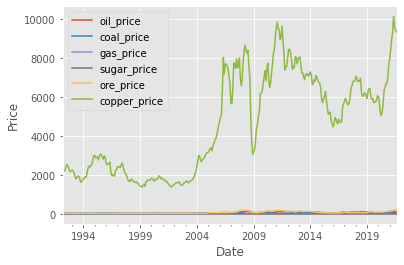

In [11]:
style.use('ggplot')
df.plot(y = continuous_features)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

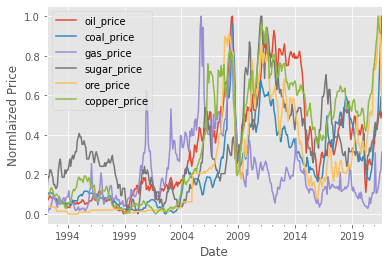

In [12]:
df_min_max_scaled = df.copy()
for column in df:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
df_min_max_scaled.plot(y = continuous_features)
plt.xlabel('Date')
plt.ylabel('Normlaized Price')
plt.show()

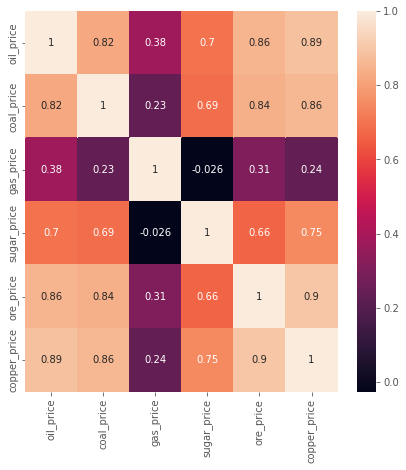

In [13]:
cor_mat = df.corr()
fig = plt.figure(figsize=(7, 7))
sns.heatmap(cor_mat,annot = True)
plt.show()

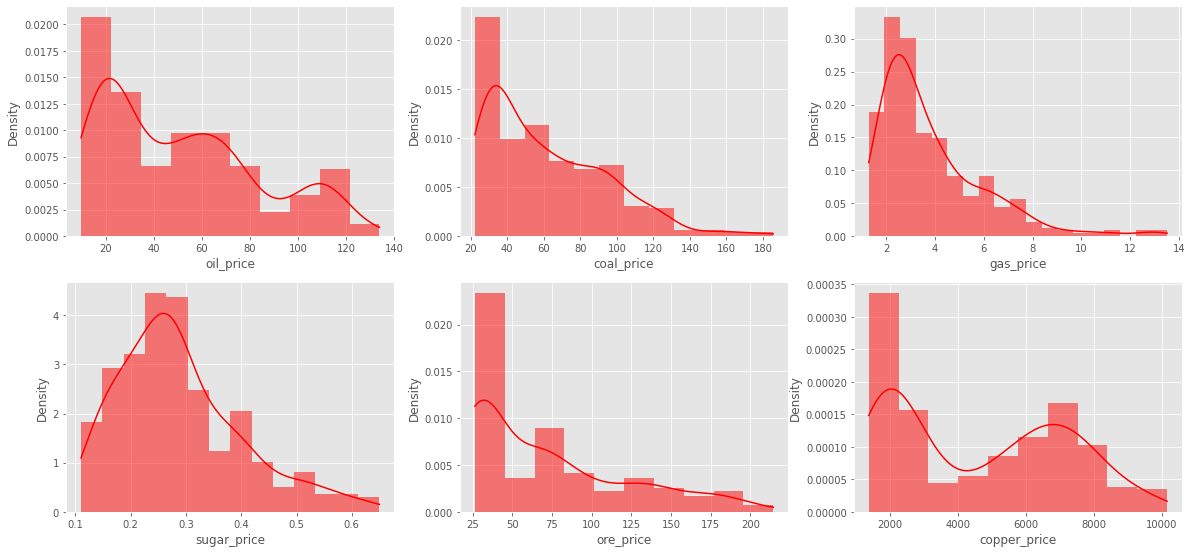

In [14]:
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(df[feature], color = "red", kde = True, stat = "density", linewidth = 0)
    plotnumber+=1
plt.show()

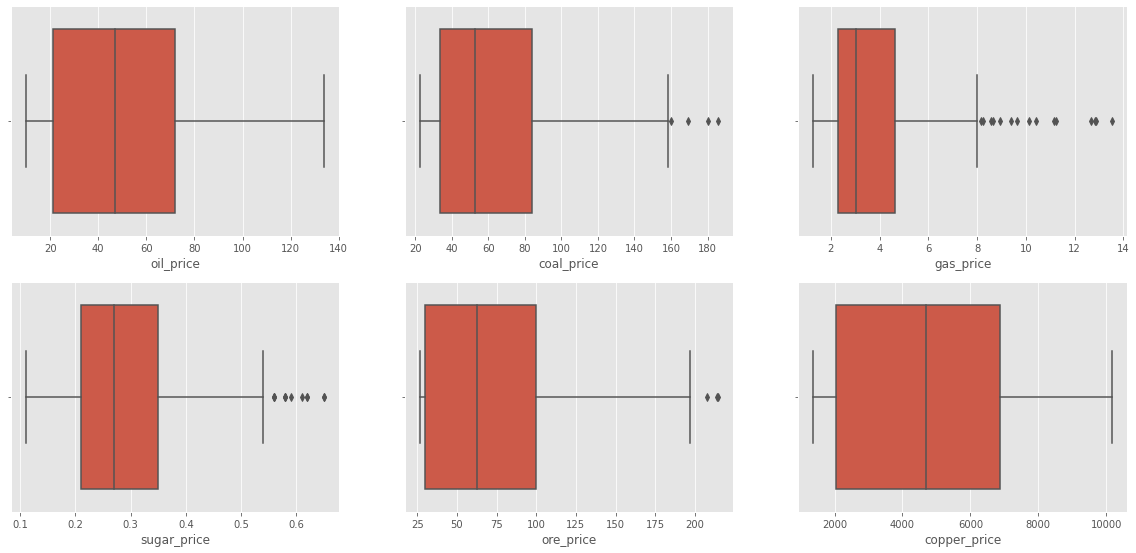

In [15]:
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.boxplot(x = df[feature])
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

# Selecting Best Model

In [16]:
def find_best_model_using_gridsearchcv(x, y):
    algos = {
        'DecisionTreeRegressor': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error','friedman_mse'],
                'splitter': ['best']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'criterion': ['squared_error'],
                'max_depth': range(2, 4, 1),
                'max_features': ['auto','log2']
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'objective': ['reg:squarederror'],
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [2, 3],
                'n_estimators': [10, 50, 100, 200]
            }
        },
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {}
        }

    }
    scores = []
    #cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    cv = TimeSeriesSplit(n_splits = 5, test_size = 12)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
        gs.fit(x,y)
        scores.append({
            'model':algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

# Price Predictions by Combined Dataset

# Target

In [17]:
target = 'sugar_price' #oil_price, coal_price, gas_price, sugar_price, ore_price, copper_price

# Anyalysis

In [18]:
print(cor_mat[target])

oil_price       0.697577
coal_price      0.687061
gas_price      -0.026112
sugar_price     1.000000
ore_price       0.663537
copper_price    0.750843
Name: sugar_price, dtype: float64


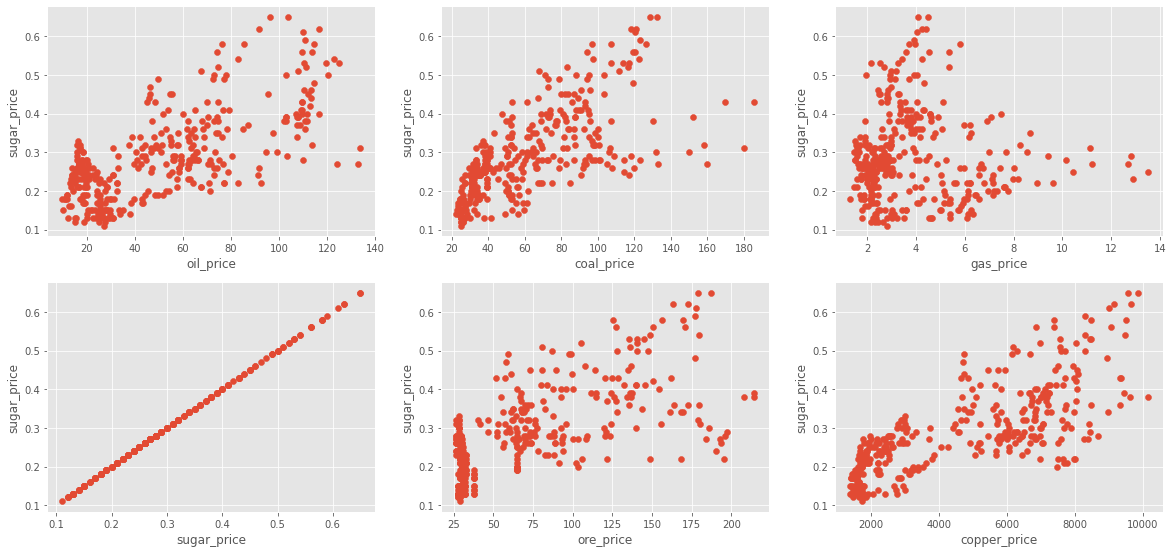

In [19]:
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    plt.scatter(df[feature], df[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plotnumber+=1
plt.show()

# Preprocessing

In [20]:
df['Y'] = df[target].shift(-forecast_out)
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price,Y
Month,,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33,0.23
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33,0.22
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52,0.21
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20,0.19
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32,0.19
...,...,...,...,...,...,...,...
2021-05-01,68.04,107.04,2.89,0.38,207.72,10161.97,0.43
2021-06-01,73.07,129.97,3.24,0.38,214.43,9631.50,NaN
2021-07-01,74.39,151.97,3.80,0.39,214.14,9450.82,NaN


In [21]:
X = np.array(df.drop(['Y'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
print(len(X))
X

351


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


array([[-1.0461089 , -0.66305104, -1.18736146, -0.96477291, -0.79982726,
        -0.94164386],
       [-1.00440263, -0.66305104, -1.09854406, -0.69830944, -0.79982726,
        -0.94636024],
       [-0.97505378, -0.66305104, -1.04244887, -0.69830944, -0.79982726,
        -0.94589254],
       ...,
       [ 0.42411422,  1.03055497, -0.58901271,  0.45636561,  1.93427589,
         1.71561446],
       [ 0.41113894,  0.94804439, -0.56563971,  0.63400792,  2.17007913,
         1.84789726],
       [ 0.51216078,  1.40093578, -0.43475093,  0.81165024,  2.73459006,
         2.17692405]])

In [22]:
y = np.array(df['Y'])
y = y[:-forecast_out]
print(len(y))
y

351


array([0.23, 0.22, 0.21, 0.19, 0.19, 0.18, 0.18, 0.19, 0.23, 0.25, 0.26,
       0.23, 0.21, 0.21, 0.21, 0.23, 0.22, 0.23, 0.23, 0.24, 0.26, 0.24,
       0.26, 0.27, 0.26, 0.27, 0.28, 0.28, 0.31, 0.32, 0.33, 0.32, 0.32,
       0.3 , 0.3 , 0.31, 0.3 , 0.29, 0.26, 0.26, 0.26, 0.27, 0.28, 0.28,
       0.28, 0.26, 0.25, 0.27, 0.28, 0.27, 0.26, 0.25, 0.24, 0.24, 0.24,
       0.24, 0.24, 0.25, 0.24, 0.25, 0.25, 0.26, 0.25, 0.25, 0.26, 0.27,
       0.25, 0.24, 0.22, 0.21, 0.2 , 0.18, 0.19, 0.19, 0.16, 0.16, 0.18,
       0.18, 0.18, 0.15, 0.13, 0.12, 0.13, 0.13, 0.12, 0.13, 0.15, 0.15,
       0.14, 0.13, 0.12, 0.12, 0.11, 0.13, 0.15, 0.18, 0.21, 0.23, 0.22,
       0.24, 0.22, 0.22, 0.23, 0.22, 0.2 , 0.19, 0.21, 0.2 , 0.19, 0.18,
       0.17, 0.15, 0.17, 0.17, 0.17, 0.14, 0.15, 0.15, 0.13, 0.13, 0.14,
       0.14, 0.15, 0.17, 0.17, 0.18, 0.18, 0.2 , 0.18, 0.17, 0.16, 0.15,
       0.15, 0.15, 0.13, 0.13, 0.13, 0.14, 0.13, 0.13, 0.14, 0.15, 0.14,
       0.15, 0.17, 0.17, 0.17, 0.19, 0.18, 0.18, 0.

# GridsearchCV result

In [23]:
pd.set_option('display.max_colwidth', 100)
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,DecisionTreeRegressor,-4.478972,"{'criterion': 'squared_error', 'splitter': 'best'}"
1,RandomForestRegressor,-0.070651,"{'criterion': 'squared_error', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 10}"
2,XGBRegressor,-1.157335,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'objective': 'reg:squarederror'}"
3,LinearRegression,-1.683558,{}


# Model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.03, shuffle=False)

In [25]:
clf = RandomForestRegressor(criterion =  'squared_error', max_depth = 2, n_estimators = 10, max_features = 'auto')
#clf = XGBRegressor(learning_rate = 0.01, max_depth = 3, n_estimators = 200, objective = 'reg:squarederror')
#clf = LinearRegression()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

-1.3206095036154202


In [26]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan
forecast_set

array([0.52338509, 0.52338509, 0.52338509, 0.4597622 ])

In [27]:
for i in forecast_set:
    next_date = df.iloc[-1].name + relativedelta(months=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [28]:
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price,Y,Forecast
Month,,,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33,0.23,NaN
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33,0.22,NaN
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52,0.21,NaN
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20,0.19,NaN
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32,0.19,NaN
...,...,...,...,...,...,...,...,...
2021-09-01,74.60,185.69,5.11,0.43,124.52,9324.71,NaN,NaN
2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.523385
2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.523385


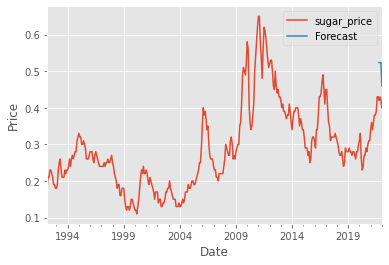

In [29]:
odf[target].plot()
df['Forecast'].plot()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

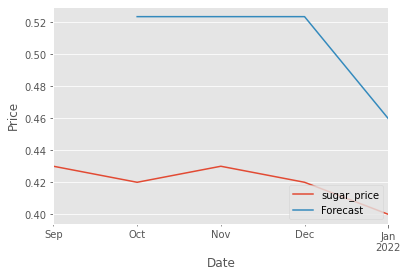

In [30]:
odf.tail(forecast_out+1)[target].plot()
df.tail(forecast_out)['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [31]:
print(df['Forecast'])

Month
1992-03-01         NaN
1992-04-01         NaN
1992-05-01         NaN
1992-06-01         NaN
1992-07-01         NaN
                ...   
2021-09-01         NaN
2021-10-01    0.523385
2021-11-01    0.523385
2021-12-01    0.523385
2022-01-01    0.459762
Name: Forecast, Length: 359, dtype: float64


In [32]:
print(odf[target])

Month
1992-03-01    0.18
1992-04-01    0.21
1992-05-01    0.21
1992-06-01    0.23
1992-07-01    0.23
              ... 
2021-09-01    0.43
2021-10-01    0.42
2021-11-01    0.43
2021-12-01    0.42
2022-01-01    0.40
Name: sugar_price, Length: 359, dtype: float64
